In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
cd /content/gdrive/My Drive/project/new_test

/content/gdrive/My Drive/project/new_test


In [0]:
cd check1

/content/gdrive/My Drive/project/new_test/check1


In [0]:
!pwd

/content/gdrive/My Drive/project/new_test/check1


In [0]:
!wget http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar

--2019-08-04 08:28:43--  http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 793579520 (757M) [application/x-tar]
Saving to: ‘images.tar’

images.tar          100%[===================>] 756.82M  46.2MB/s    in 18s     

2019-08-04 08:29:01 (42.2 MB/s) - ‘images.tar’ saved [793579520/793579520]



In [0]:
! tar -xf images.tar

^C


In [0]:
## Training Dataset

import cv2
import glob 

count = 1

# path to input color images 

dog_path1 = 'Images/n02085620-Chihuahua/*.jpg'
dog_path2 = 'Images/n02085782-Japanese_spaniel/*.jpg'
dog_path3 = 'Images/n02085936-Maltese_dog/*.jpg'
dog_path4 = 'Images/n02086079-Pekineses/*.jpg'
dog_path5 = 'Images/n02086240-Shih-Tzu/*.jpg'

paths_list = [dog_path1, dog_path2, dog_path3, dog_path4, dog_path5]

for path in paths_list:
    
    filenames = glob.glob(path)

    for filename in filenames:
        
        image = cv2.imread(filename)
        gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        image = cv2.resize(image, (128, 128))
        gray_img = cv2.resize(gray_img, (128, 128))
        
        # path to store color and grayscale images for fruther rendering
    
        cv2.imwrite("grayscale/gray_" +str(count) +".jpg", gray_img)
        cv2.imwrite("color/color_" +str(count) +".jpg", image)
    
        count += 1

In [0]:
## Testing Dataset

# path to test image dataset for configure it according to our tensors i.e. (128,128)

filenames = gl.glob("test/*.jpg")
#print(filenames)

count1 = 1
for file in filenames:
  img = cv2.imread(file)    
  img = cv2.resize(img, (128, 128))
  
  cv2.imwrite('color_test/test_' +str(count1) +'.jpg', img)
  count1 += 1
  

In [0]:
!pwd

/content/gdrive/My Drive/project/new_test/check1


In [0]:
x= cv2.imread('color/color_1.jpg')
print(x.shape)

(128, 128, 3)


In [0]:
## Creating numpy arrays for rensdering in tensor cores

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig

num_images = 803

dataset = []

for i in range(1, num_images+1):
    img = cv2.imread("color/color_" +str(i) +".jpg" )
    dataset.append(np.array(img))

dataset_source = np.asarray(dataset)
print(dataset_source.shape)

dataset_tar = []

for i in range(1, num_images+1):
    img = cv2.imread("grayscale/gray_" +str(i) +".jpg", 0)    
    dataset_tar.append(np.array(img))

dataset_target = np.asarray(dataset_tar)
print(dataset_target.shape)

(803, 128, 128, 3)
(803, 128, 128)


In [0]:
dataset_target = dataset_target[:, :, :, np.newaxis]

In [0]:
## Defining autoencoder using Advance Keras for colourinzing as base 

def autoencoder(inputs):
    
    # Encoder
    
    net = tf.layers.conv2d(inputs, 128, 2, activation = tf.nn.relu)
    print(net.shape)
    net = tf.layers.max_pooling2d(net, 2, 2, padding = 'same')
    print(net.shape)

    # Decoder
    
    net = tf.image.resize_nearest_neighbor(net, tf.constant([129, 129]))
    net = tf.layers.conv2d(net, 1, 2, activation = None, name = 'outputOfAuto')

    print(net.shape)
    
    return net

In [0]:
## creating network or architecture of our network

ae_inputs = tf.placeholder(tf.float32, (None, 128, 128, 3), name = 'inputToAuto')
ae_target = tf.placeholder(tf.float32, (None, 128, 128, 1))

ae_outputs = autoencoder(ae_inputs)
lr = 0.001

loss = tf.reduce_mean(tf.square(ae_outputs - ae_target))
train_op = tf.train.AdamOptimizer(learning_rate = lr).minimize(loss)


# Intialize the network 
init = tf.global_variables_initializer()

W0804 08:52:11.575613 140111849617280 deprecation.py:323] From <ipython-input-17-d48f935efb09>:5: conv2d (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
W0804 08:52:11.582711 140111849617280 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0804 08:52:11.826968 140111849617280 deprecation.py:323] From <ipython-input-17-d48f935efb09>:7: max_pooling2d (from tensorflow.python.layers.pooling) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.MaxPooling2D instead.


(?, 127, 127, 128)
(?, 64, 64, 128)
(?, 128, 128, 1)


In [0]:
# defining input to tensor for model to create

batch_size = 32
epoch_num = 50

# saving graph/ model to drive
saving_path = 'Model/ColorToGray.ckpt'

saver_ = tf.train.Saver(max_to_keep = 3)

batch_img = dataset_source[0:batch_size]
batch_out = dataset_target[0:batch_size]

num_batches = num_images//batch_size

sess = tf.Session()
sess.run(init)

for ep in range(epoch_num):
    batch_size = 0
    for batch_n in range(num_batches): # batches loop

        _, c = sess.run([train_op, loss], feed_dict = {ae_inputs: batch_img, ae_target: batch_out})
        print("Epoch: {} - cost = {:.5f}" .format((ep+1), c))
            
        batch_img = dataset_source[batch_size: batch_size+32]
        batch_out = dataset_target[batch_size: batch_size+32]
            
        batch_size += 32
    
    saver_.save(sess, saving_path, global_step = ep)
recon_img = sess.run([ae_outputs], feed_dict = {ae_inputs: batch_img})

sess.close()

Epoch: 1 - cost = 22607.77539
Epoch: 1 - cost = 18572.14062
Epoch: 1 - cost = 14178.51758
Epoch: 1 - cost = 11749.11133
Epoch: 1 - cost = 9857.07812
Epoch: 1 - cost = 6772.25049
Epoch: 1 - cost = 5089.29590
Epoch: 1 - cost = 2931.35327
Epoch: 1 - cost = 1650.01025
Epoch: 1 - cost = 805.30060
Epoch: 1 - cost = 397.41412
Epoch: 1 - cost = 374.47864
Epoch: 1 - cost = 664.01099
Epoch: 1 - cost = 1269.34290
Epoch: 1 - cost = 1617.36047
Epoch: 1 - cost = 2009.67688
Epoch: 1 - cost = 1879.44629
Epoch: 1 - cost = 1939.84937
Epoch: 1 - cost = 1760.61890
Epoch: 1 - cost = 1758.86304
Epoch: 1 - cost = 1741.73193
Epoch: 1 - cost = 1245.84802
Epoch: 1 - cost = 938.90082
Epoch: 1 - cost = 644.40540
Epoch: 1 - cost = 600.22504
Epoch: 2 - cost = 467.52005
Epoch: 2 - cost = 421.22678
Epoch: 2 - cost = 417.79987
Epoch: 2 - cost = 414.05054
Epoch: 2 - cost = 472.37485
Epoch: 2 - cost = 512.64709
Epoch: 2 - cost = 630.74170
Epoch: 2 - cost = 585.25671
Epoch: 2 - cost = 632.28918
Epoch: 2 - cost = 657.1723

W0804 08:54:05.012343 140111849617280 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:960: remove_checkpoint (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to delete files with this prefix.


Epoch: 4 - cost = 189.08574
Epoch: 4 - cost = 248.25894
Epoch: 5 - cost = 230.12939
Epoch: 5 - cost = 240.41173
Epoch: 5 - cost = 249.99725
Epoch: 5 - cost = 213.50893
Epoch: 5 - cost = 209.76891
Epoch: 5 - cost = 197.54562
Epoch: 5 - cost = 210.35338
Epoch: 5 - cost = 158.46631
Epoch: 5 - cost = 162.72592
Epoch: 5 - cost = 199.38101
Epoch: 5 - cost = 177.40140
Epoch: 5 - cost = 157.91780
Epoch: 5 - cost = 138.46582
Epoch: 5 - cost = 164.71567
Epoch: 5 - cost = 151.01523
Epoch: 5 - cost = 153.60915
Epoch: 5 - cost = 114.13736
Epoch: 5 - cost = 159.72238
Epoch: 5 - cost = 110.79034
Epoch: 5 - cost = 151.67374
Epoch: 5 - cost = 253.51277
Epoch: 5 - cost = 194.26718
Epoch: 5 - cost = 180.52068
Epoch: 5 - cost = 155.29251
Epoch: 5 - cost = 206.49800
Epoch: 6 - cost = 193.64935
Epoch: 6 - cost = 195.99197
Epoch: 6 - cost = 199.86859
Epoch: 6 - cost = 171.74069
Epoch: 6 - cost = 163.09352
Epoch: 6 - cost = 159.44876
Epoch: 6 - cost = 175.67740
Epoch: 6 - cost = 127.35999
Epoch: 6 - cost = 13

In [0]:
## restoring model to exploit it!!!!

saver = tf.train.Saver()

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

saver.restore(sess, 'Model/ColorToGray.ckpt-49')

In [0]:
!pwd

/content/gdrive/My Drive/project/new_test/check1


In [0]:
## creating numpy array of testing data


filenames = gl.glob('color_test/test_*.jpg')

test_data = []
for file in filenames[0:100]:
  #print(file)
  test_data.append(np.array(plt.imread(file)))

test_dataset = np.asarray(test_data)
print(test_dataset.shape)

# Running the test data on the autoencoder
batch_imgs = test_dataset

gray_imgs = sess.run(ae_outputs, feed_dict = {ae_inputs: batch_imgs})

(100, 128, 128, 3)


In [0]:
## saving genrated data to drive i.e. in grayscale

print(gray_imgs.shape)

for i in range(gray_imgs.shape[0]):
    cv2.imwrite('generated_images/gen_gray_' +str(i) +'.jpeg', gray_imgs[i])
    
    

(100, 128, 128, 1)


gen_gray_5.jpeg


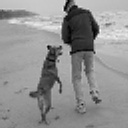

In [0]:
## to show image 

import os, random
from IPython.display import Image

files = r'generated_images'

a=random.choice(os.listdir(files))
print(a)

file = files + '/' + a


Image(file)